In [1]:
import pandas as pd

# Load the production Dataset
df_yeild = pd.read_csv("/Users/luffy_015/Desktop/Agriculture/dxm437/apy_.csv")

# Load the crop price dataset
df_price = pd.read_csv("/Users/luffy_015/Desktop/Agriculture/dxm437/market_price_cleaned.csv", keep_default_na=False)

In [2]:
df_yeild

,State,District,Crop,Crop_Year,Season,Area,Production,Yield
0,Andaman and Nicobar Island,NICOBARS,Arecanut,2007-01-01,Kharif,2439.6,3415.0,1.40
1,Andaman and Nicobar Island,NICOBARS,Arecanut,2007-01-01,Rabi,1626.4,2277.0,1.40
2,Andaman and Nicobar Island,NICOBARS,Arecanut,2008-01-01,Autumn,4147.0,3060.0,0.74
3,Andaman and Nicobar Island,NICOBARS,Arecanut,2008-01-01,Summer,4147.0,2660.0,0.64
4,Andaman and Nicobar Island,NICOBARS,Arecanut,2009-01-01,Autumn,4153.0,3120.0,0.75
...,...,...,...,...,...,...,...,...
212043,West Bengal,PURULIA,Wheat,2015-01-01,Rabi,855.0,1241.0,1.45
212044,West Bengal,PURULIA,Wheat,2016-01-01,Rabi,1366.0,2415.0,1.77
212045,West Bengal,PURULIA,Wheat,2017-01-01,Rabi,1052.0,2145.0,2.04
212046,West Bengal,PURULIA,Wheat,2018-01-01,Rabi,833.0,2114.0,2.54


In [3]:
# Convert and reset index
df_yeild['Crop_Year'] = pd.to_datetime(df_yeild['Crop_Year'], errors='coerce').dt.year
df_yeild.reset_index(drop=True, inplace=True)

In [4]:
from scipy.stats import zscore

df_yeild['z_score'] = zscore(df_yeild['Yield'])
df_yeild = df_yeild[(df_yeild['z_score'] > -3) & (df_yeild['z_score'] < 3)]
df_yeild.drop(columns=['z_score'], inplace=True)

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_5301/200429650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yeild.drop(columns=['z_score'], inplace=True)


In [5]:
df_price

,State,District,Market Name,Commodity Name,Variety Of Commodities,Year,Min_Price,Max_Price,Modal_Price,Price_Range
0,Gujarat,Amreli,Amreli,Ajwan,Other,2016-01-01,8155.0,12250.0,12250.0,4095.0
1,Gujarat,Jamnagar,Jamnagar,Ajwan,Other,2016-01-01,10625.0,18500.0,14563.0,7875.0
2,Madhya Pradesh,Shivpuri,Pohari,Ajwan,Other,2016-01-01,5840.0,9200.0,7595.0,3360.0
3,Madhya Pradesh,Shivpuri,Shivpuri,Ajwan,Other,2016-01-01,7165.0,7165.0,7165.0,0.0
4,Maharashtra,Buldhana,Shegaon,Ajwan,Other,2016-01-01,9100.0,9100.0,9100.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21861643,Madhya Pradesh,Ratlam,Jaora,poppy seeds,Khaskhas,2024-01-01,90000.0,131000.0,128000.0,41000.0
21861644,Madhya Pradesh,Neemuch,Neemuch,poppy seeds,Poppy seed,2024-01-01,60000.0,111000.0,95000.0,51000.0
21861645,Madhya Pradesh,Neemuch,Neemuch,poppy seeds,Khaskhas,2024-01-01,84000.0,92900.0,91000.0,8900.0
21861646,Madhya Pradesh,Ratlam,Jaora,poppy seeds,Khaskhas,2024-01-01,68720.0,125000.0,104600.0,56280.0


In [6]:
df_yeild.isna().sum()

State         0
District      0
Crop          0
Crop_Year     0
Season        0
Area          0
Production    0
Yield         0
dtype: int64

In [7]:
df_price.isna().sum()

State                     0
District                  0
Market Name               0
Commodity Name            0
Variety Of Commodities    0
Year                      0
Min_Price                 0
Max_Price                 0
Modal_Price               0
Price_Range               0
dtype: int64

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import joblib

# Define columns
cat_cols = ["Crop", "Season", "State", "District"]  # include all categorical columns
num_cols = ["Area", "Production", "Crop_Year"]

# Column transformer: encode categoricals, scale numerics
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", MinMaxScaler(), num_cols)
    ]
)

# XGB model
xgb = XGBRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42,
    tree_method="hist", n_jobs=-1
)

# Full pipeline
pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", xgb)
])

# Train/test split
x = df_yeild[cat_cols + num_cols]
y = df_yeild["Yield"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit pipeline
pipeline.fit(x_train, y_train)

# Evaluate
y_pred = pipeline.predict(x_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



R2 Score: 0.9743994841995419
RMSE: 0.09664167463892913


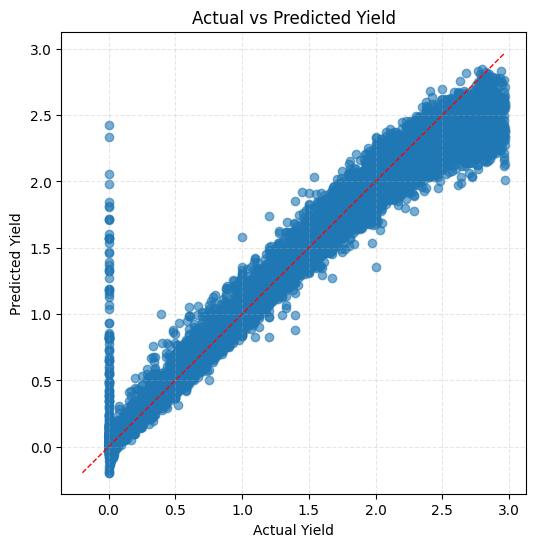

In [10]:
# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', lw=1)
plt.xlabel("Actual Yield"); plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield")
plt.grid(True, ls="--", alpha=0.3)
plt.show()

In [11]:
# Save pipeline
joblib.dump(pipeline, "crop_yield.joblib")


['crop_yield.joblib']